In [ ]:
!pip install sklearn
!pip install quantulum3
!pip install transformers
!pip install nltk

In [ ]:
import os
import re
import io
import pandas as pd
import ast 
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel, BertForPreTraining
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torchtext import vocab
from torchtext import data    
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

import nltk
from sklearn.model_selection import train_test_split
import re
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/MeasEval-main/data/train/train/tsv

/content/drive/My Drive/MeasEval-main/data/train/train/tsv


In [ ]:
files=os.listdir()

In [ ]:
cd /content/drive/My Drive/MeasEval-main/data/train/dev/text

/content/drive/My Drive/MeasEval-main/data/train/dev/text


In [ ]:
files_val=os.listdir()

In [ ]:
cd /content/drive/My Drive/MeasEval-main/data/train/train

/content/drive/My Drive/MeasEval-main/data/train/train


In [ ]:
train=[]
for i in files:
  
  pathtsv=os.path.join('tsv',i[:-3]+'tsv')
  if(not(os.path.exists(pathtsv))):
    continue
  
  filetsv=pd.read_csv(pathtsv,sep = '\t')
  
  entity=filetsv[['annotType','text','other']]
  quant=entity[entity['annotType']=='Quantity']
  quant=quant[['text','other']]
  quant = quant.to_numpy().tolist()
  train.append(quant)
  
  
  
  

In [ ]:
cd /content/drive/My Drive/MeasEval-main/data/train/dev

/content/drive/My Drive/MeasEval-main/data/train/dev


In [ ]:
test=[]
for i in files_val:
  
  pathtsv=os.path.join('tsv',i[:-3]+'tsv')
  if(not(os.path.exists(pathtsv))):
    continue
  
  filetsv=pd.read_csv(pathtsv,sep = '\t')
  
  entity=filetsv[['annotType','text','other']]
  quant=entity[entity['annotType']=='Quantity']
  quant=quant[['text','other']]
  quant = quant.to_numpy().tolist()
  test.append(quant)
  
  
  
  

In [ ]:
X=[]
label=[]
for i in train:
  for j in i:
    temp=[]
  
    X.append(j[0])
    
    
    
    
    other=j[1]
    
    if(not pd.isnull(other)):
      dictio=ast.literal_eval(other) 
    
      
      if 'unit' in dictio:
        t=j[0].find(dictio['unit'])
        
        t=[m.start() for m in re.finditer(dictio['unit'],j[0])]
        sz=len(dictio['unit'])
        span=[]
        for k in t:
          span.append((k,k+sz))
        
        
        label.append(span)
        

      else:
        label.append([])
    else:
      label.append([])
  
    

In [ ]:
X_train=[]
y_train=[]
for i in range(len(X)):

  character=list(X[i]);
  X_train.append(character)
  l=np.zeros(64)
  
  for k in label[i]:
    l[k[0]:k[1]]=1;
  y_train.append(l)
  

In [ ]:
X=[]
label=[]
for i in test:
  for j in i:
    temp=[]
  
    X.append(j[0])
    
    
    
    
    other=j[1]
    
    if(not pd.isnull(other)):
      dictio=ast.literal_eval(other) 
    
      
      if 'unit' in dictio:
        t=j[0].find(dictio['unit'])
        
        t=[m.start() for m in re.finditer(dictio['unit'],j[0])]
        sz=len(dictio['unit'])
        span=[]
        for k in t:
          span.append((k,k+sz))
        
        
        label.append(span)
        

      else:
        label.append([])
    else:
      label.append([])
  
    

In [ ]:
X_test=[]
y_test=[]
for i in range(len(X)):

  character=list(X[i]);
  X_test.append(character)
  l=np.zeros(64)
  
  for k in label[i]:
    l[k[0]:k[1]]=1;
  y_test.append(l)
  

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

907
907
98
98


In [ ]:
X_train,X_val,y_train,y_val= X_train,X_test,y_train,y_test

In [ ]:

TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)
TEXT.build_vocab(X_train, max_size=1000)


In [ ]:
vocab_size=len(TEXT.vocab)

In [ ]:
vocab_size

91

In [ ]:
X_train=TEXT.process(X_train)[0]
X_val=TEXT.process(X_val)[0]

X_train[0]

tensor([30,  7, 18, 18,  2, 10, 27, 11, 14,  2,  9, 16,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [ ]:
row=X_train.shape[1]
X_train=F.pad(input=X_train, pad=(0, 64-row, 0, 0), mode='constant', value=1)

row=X_val.shape[1]
X_val=F.pad(input=X_val, pad=(0, 64-row, 0, 0), mode='constant', value=1)


In [ ]:
train_data = TensorDataset(X_train, torch.from_numpy(np.asarray(y_train)))
val_data = TensorDataset(X_val,torch.from_numpy(np.array(y_val)))

In [ ]:
batch_size = 38
train_loader = DataLoader(train_data, shuffle=True, batch_size = batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size = batch_size)

In [ ]:
lr = 1e-4

In [ ]:
class bilstm(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.output_size = output_size
        
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                         batch_first=True, bidirectional=True)
        
        self.dropout = nn.Dropout(0)
        self.fc = nn.Linear(hidden_dim*2,output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        embeds = self.embedding(x)
        lstm, (hn,cn)= self.lstm(embeds)
        
        output = self.dropout(lstm)
        output = self.fc(output)
        output = self.sigmoid(output) 
        return output

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = bilstm(vocab_size, 1, 100, 32, 1)
model = model.to(device)

In [ ]:
from transformers import AdamW

criterion = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
model = torch.load('/content/drive/My Drive/Model/units_t75_96f1.pt')

In [ ]:
epochs = 40
for e in range(epochs):
  
  model.train()
  i=0
  train_loss=0
  for seq, y in train_loader:
    model.zero_grad()
    
    y_pred = model(seq.to(device))
    # print(y_pred.shape)
    loss = criterion(y_pred,y.to(device).float())
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*batch_size
    if(i%5==0):
      print("Epoch-{}/{} Iterations-{} loss-{}".format(e+1,epochs,i+1,loss.item()))
    i+=1
  
  
  model.eval()
  val_loss=0
  for seq, y in val_loader:
    model.zero_grad()
    y_pred = model(seq.to(device))
    loss = criterion(y_pred,y.to(device).float())
    val_loss += loss.item()*batch_size
    
    i+=1
  # if(e%5==0):
  #   torch.save(bert_model,'/content/drive/My Drive/Model/bert_{}.pt'.format(e))
  
  print("Epoch-{}/{} train_loss-{} Val_loss-{}".format(e+1,epochs,train_loss/len(train_loader),val_loss/len(val_loader)))


In [ ]:
pos=0
neg=0
units=[]
for seq, y in val_loader:
    model.zero_grad()
    model.eval()
    y_pred = model(seq.to(device))
    np_out = y_pred.cpu().data.numpy()
    np_act = y.cpu().data.numpy()
    
    np_out=np_out>=0.07

    
    
    
    
    
    for i in range(np_out.shape[0]):
     for j in range(np_out.shape[1]):
       if (np_out[i,j])==1 or (np_act[i,j])==1:
           if (np_out[i,j])==1 and (np_act[i,j])==1:
             pos = pos + 1
           else:
             neg = neg + 1

print(pos/(pos+neg))


0.7881040892193308


In [ ]:
import matplotlib.pyplot as plt

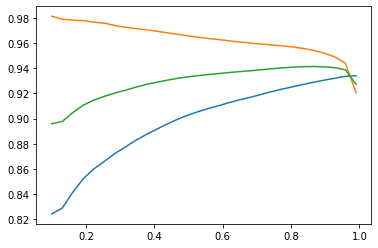

[0.8672413793103448]


In [ ]:

best_threshold=[]
for k in range(1):
  m=0
  best_t=0
  prec_num = 0 
  prec_den = 0
  rec_num = 0
  rec_den = 0 
  threshold = np.linspace(0.1,0.99,30)
  f1 = []
  pre = []
  rec = []
  for t in threshold:
    for seq, y in val_loader:
      model.zero_grad()
      model.eval()
      y_pred = model(seq.to(device))
      np_out = y_pred.cpu().data.numpy()
      np_act = y.cpu().data.numpy()
      #print(np_out)
    
      for i in range(np_out.shape[0]):
        for j in range(np_out.shape[1]):
        
          if np_out[i][j]>=t:
            np_out[i][j]=1
          else:
            np_out[i][j]=0

      for i in range(np_out.shape[0]):
        for j in range(np_out.shape[1]):
          if np_out[i,j]==1:
            if np_out[i,j]==np_act[i,j]:
              prec_num = prec_num + 1
            else:
              prec_den = prec_den + 1
          if np_act[i,j]==1:
            if np_out[i,j]==np_act[i,j]:
              rec_num = rec_num + 1
            else:
              rec_den = rec_den + 1

    precision = prec_num/(prec_num+prec_den)
    recall = rec_num/(rec_num+rec_den)
    F1 = 2*precision*recall/(precision+recall)
    f1.append(F1)
    pre.append(precision)
    rec.append(recall)
    if F1>m:
      best_t = t
    m = max(m,F1)
  best_threshold.append(best_t)
  plt.plot(threshold,pre)
  plt.plot(threshold,rec)
  plt.plot(threshold,f1)
  plt.show()
print(best_threshold)

In [ ]:
p=0
n=0
pos=0
neg=0
prec_num = 0 
prec_den = 0
rec_num = 0
rec_den = 0 
p1 = 0
n1=0
for seq, y in val_loader:
    model.zero_grad()
    model.eval()
    y_pred = model(seq.to(device))
    np_out = y_pred.cpu().data.numpy()
    np_act = y.cpu().data.numpy()
    #print(np_out)
    
    for i in range(np_out.shape[0]):
      for j in range(np_out.shape[1]):
          t=0.75
          if np_out[i][j]>=t:
            np_out[i][j]=1
          else:
            np_out[i][j]=0


    for i in range(np_out.shape[0]):
      for j in range(np_out.shape[1]):
          if np_out[i,j] == np_act[i,j]:
            p = p +1
          else:
            n=n+1
          if (np_out[i,j])==1 or (np_act[i,j])==1:
            if (np_out[i,j])==1 and (np_act[i,j])==1:
              pos = pos + 1
            else:
              neg = neg + 1
          if np_out[i,j]==1:
            if np_out[i,j]==np_act[i,j]:
              prec_num = prec_num + 1
            else:
              prec_den = prec_den + 1
          if np_act[i,j]==1:
            if np_out[i,j]==np_act[i,j]:
              rec_num = rec_num + 1
            else:
              rec_den = rec_den + 1

precision = prec_num/(prec_num+prec_den)
recall = rec_num/(rec_num+rec_den)
F1 = 2*precision*recall/(precision+recall)


print("--------UNIT DETECTION RESULTS--------")
print("Accuracy:-" + str(p/(n+p)))
print("Modified Accuracy:-" + str(pos/(pos+neg)))
print("Precision:-" + str(precision))
print("Recall:-" + str(recall))
print("F1 score:-"+str(F1))

--------UNIT DETECTION RESULTS--------
Accuracy:-0.9971301020408163
Modified Accuracy:-0.918552036199095
Precision:-0.9712918660287081
Recall:-0.9441860465116279
F1 score:-0.9575471698113208
